# Tutorial 1: How to Apply Geom3D On Your Customized Data

## Step 1. Load Packages and Set Random Seeds and Device

In [1]:
import numpy as np
import torch
from geom3d.models import SchNet
import stk
import pymongo
import numpy as np
import os
import pandas as pd
from geom3d import Database_utils
#%% 
# Load the searched space
from pathlib import Path
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
seed = 42
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)


device = "cuda" if torch.cuda.is_available() else torch.device("cpu")

In [43]:
from geom3d import test_train

'c:\\Users\\ma11115\\OneDrive - Imperial College London\\Geom3d\\Geom3D\\notebook'

In [52]:
from geom3d import config_utils
importlib.reload(config_utils)
dir = os.getcwd()+"/config_test2"
config = config_utils.read_config(dir)


In [53]:
dir

'c:\\Users\\ma11115\\OneDrive - Imperial College London\\Geom3d\\Geom3D\\notebook/config_test2'

In [61]:
importlib.reload(test_train)
test_train.main(str(dir))

C:\Users\ma11115\OneDrive - Imperial College London\Geom3d\Geom3D\src\geom3d\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


train_idx:  [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13 24  3 17 38  8 78  6 64 36 89 56 99 54 43 50 67 46 68 61 97 79 41
 58 48 98 57 75 32 94 59]
valid_idx:  [63 84 37 29  1 52 21  2 23 87]
test_idx:  [91 74 86 82 20 60 71 14 92 51]


FileNotFoundError: [WinError 2] The system cannot find the file specified: 'C:/Users/ma11115/OneDrive - Imperial College London/training'

In [359]:


STK_path = "C:/Users/ma11115/OneDrive - Imperial College London/github_folder/STK_search"
#STK_path = "/rds/general/user/ma11115/home/STK_Search/STK_search"
df_path = Path(STK_path,  'data/output/Full_dataset/df_total_2023_11_09.csv')

df_precursors_path = Path(STK_path,  'data/output/Prescursor_data/calculation_data_precursor_071123_clean.pkl')
df_total, df_precursors = Database_utils.load_data_from_file(df_path, df_precursors_path)

C:\Users\ma11115\OneDrive - Imperial College London\Geom3d\Geom3D\src\geom3d\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


## Step 2. Data Loading

The geometric data on small molecules, proteins, and crystal materials can be in many formats:
- SDF
- CIF
- HDF5

The most important thing is to extract the atom types and coordinates. Below we show two simple data points using customized information.

In [362]:
print(df_total.columns.values)

['_id_x' 'InChIKey' 'BB' 'aI' 'bI' 'nBB' '_id_y'
 'Excited state energy (eV)' 'Excited state oscillator strength'
 'Host IP_x' 'cal_folder_x' '_id' 'Host IP_y' 'electron affinity (eV)'
 'homo lumo_gap (eV)' 'ionisation potential (eV)' 'total energy (au)'
 'cal_folder_y' 'xtb_cal_folder' 'ES1' 'fosc1' 'target' 'InChIKey_0'
 'InChIKey_1' 'InChIKey_2' 'InChIKey_3' 'InChIKey_4' 'InChIKey_5'
 'Atom_num_0_x' 'HOMO (eV)_0_x' 'LUMO (eV)_0_x' 'HOMO_LUMO_GAP (eV)_0_x'
 'IP (eV)_0_x' 'EA (eV)_0_x' '1 Excited state Energy (eV)_0_x'
 '1 Excited state Osc_0_x' '2 Excited state Energy (eV)_0_x'
 '2 Excited state Osc_0_x' '3 Excited state Energy (eV)_0_x'
 '3 Excited state Osc_0_x' 'Atom_num_1_x' 'HOMO (eV)_1_x' 'LUMO (eV)_1_x'
 'HOMO_LUMO_GAP (eV)_1_x' 'IP (eV)_1_x' 'EA (eV)_1_x'
 '1 Excited state Energy (eV)_1_x' '1 Excited state Osc_1_x'
 '2 Excited state Energy (eV)_1_x' '2 Excited state Osc_1_x'
 '3 Excited state Energy (eV)_1_x' '3 Excited state Osc_1_x'
 'Atom_num_2_x' 'HOMO (eV)_2_x' 'LUMO (eV

In [368]:
# keep only a few columns from df_total
df_total_subset = df_total[['InChIKey','target','fosc1','ES1','ionisation potential (eV)','total energy (au)','BB']]
df_total_subset.to_csv(STK_path+'/data/output/Full_dataset/df_total_subset_16_11_23.csv')

Define Molecule 0

In [157]:
client = pymongo.MongoClient("mongodb://129.31.66.201/")
database_name="stk_mohammed_BO"
db_mol = stk.ConstructedMoleculeMongoDb(
    client,
    database=database_name,
)
db_poly = stk.ConstructedMoleculeMongoDb(client, database=database_name)
def fragment_based_encoding(InChIKey,db_poly,model,model):
    polymer = db_poly.get({"InChIKey": InChIKey})
    frags = []
    for molecule in polymer.get_building_blocks():
        dat_list = list(molecule.get_atomic_positions())
        positions = np.vstack(dat_list)
        positions = torch.tensor(positions, dtype=torch.float)
        atom_types = list([atom.get_atomic_number() for atom in molecule.get_atoms()])
        atom_types = torch.tensor(atom_types, dtype=torch.long)
        molecule = Data(
            x=atom_types,
            positions=positions,
        )
        frags.append(molecule)
    original_encoding = model(batch.x, batch.positions, batch.batch)
    original_encoding = original_encoding.reshape( (-1,))
    return original_encoding


In [159]:
fragment_based_encoding(df_total['InChIKey'][1],db_poly).shape

torch.Size([768])

In [107]:
frags = []
for frag in eval(df_total['BB'][50]):
    print(frag['InChIKey'])
    InChIKey= frag['InChIKey']
    db_mol = stk.MoleculeMongoDb(client, database_name)
    molecule_0 = db_mol.get({"InChIKey": InChIKey})
    dat_list = list(molecule_0.get_atomic_positions())
    positions = np.vstack(dat_list)
    positions = torch.tensor(positions, dtype=torch.float)
    atom_types = list([atom.get_atomic_number() for atom in molecule_0.get_atoms()])
    atom_types = torch.tensor(atom_types, dtype=torch.long)

    molecule = Data(
        x=atom_types,
        positions=positions,
    )
    frags.append(molecule)
batch = Batch.from_data_list(frags)
print("molecule 0 is:\n{}\n".format(frags[0]))
print("molecule 1 is:\n{}\n".format(frags[1]))
print("The collated molecules in batch is:\n{}\n".format(batch))
print("The batch.batch field defines which atoms belong to which molecule/graph:\n{}".format(batch.batch))
print("the position in the batch", batch.x)
print("the position in the batch", batch.positions)

DNHRBCFMFYOUKM-UHFFFAOYSA-N
GKKUHQQNQBVLSW-UHFFFAOYSA-N
GKKUHQQNQBVLSW-UHFFFAOYSA-N
VQAFMTSSCUETHA-UHFFFAOYSA-N
DNHRBCFMFYOUKM-UHFFFAOYSA-N
GKKUHQQNQBVLSW-UHFFFAOYSA-N
molecule 0 is:
Data(x=[24], positions=[24, 3])

molecule 1 is:
Data(x=[13], positions=[13, 3])

The collated molecules in batch is:
DataBatch(x=[97], positions=[97, 3], batch=[97], ptr=[7])

The batch.batch field defines which atoms belong to which molecule/graph:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5])
the position in the batch tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 35, 35,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  9,  9, 35, 35,  7,  7,  8,  6,  6,  6,  6,  6,
         6,  9,  9, 35, 35,  7,  7,  8,  6,  6,  

In [139]:
original_encoding = model(batch.x, batch.positions, batch.batch)
original_encoding = original_encoding.reshape( (-1,))

In [165]:
len(list(polymer.get_building_blocks()))

6

In [140]:
class LitAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(14719, 50), nn.ReLU(), nn.Linear(50, 100))
        self.decoder =  nn.Sequential(
            nn.Linear(100, 50), nn.ReLU(), nn.Linear(50, 14719)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

torch.Size([768])

Define Molecule 1

In [143]:
molecule_1,polymer = load_molecule(df_total['InChIKey'][1],df_total['target'][1],db)
molecule_0,polymer = load_molecule(df_total['InChIKey'][0],df_total['target'][0],db)

In [146]:
for frag in polymer.get_building_blocks():
    break
frag.

<Molecule at 3227403139920>

Then we gather two molecule data into a batch. In PyG, it will gather two small graph data into one sparse graph data.

**Notice**: Typically, this is done in the Dataloader class by default.

In [9]:
data_list = [molecule_0, molecule_1]
batch = Batch.from_data_list(data_list)
print("molecule 0 is:\n{}\n".format(molecule_0))
print("molecule 1 is:\n{}\n".format(molecule_1))
print("The collated molecules in batch is:\n{}\n".format(batch))
print("The batch.batch field defines which atoms belong to which molecule/graph:\n{}".format(batch.batch))

molecule 0 is:
Data(x=[98], y=-10.980199813842773, positions=[98, 3])

molecule 1 is:
Data(x=[104], y=-11.025300025939941, positions=[104, 3])

The collated molecules in batch is:
DataBatch(x=[202], y=[2], positions=[202, 3], batch=[202], ptr=[3])

The batch.batch field defines which atoms belong to which molecule/graph:
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## Step 3. Set Model

## Step 4. Make Predictions

## Step 5. Make Dataloader

In [326]:
def load_molecule(InChIKey,target,db):
    polymer = db.get({"InChIKey": InChIKey})
    dat_list = list(polymer.get_atomic_positions())
    positions = np.vstack(dat_list)
    positions = torch.tensor(positions, dtype=torch.float)
    atom_types = list([atom.get_atom().get_atomic_number() for atom in polymer.get_atom_infos()])
    atom_types = torch.tensor(atom_types, dtype=torch.long)
    y = torch.tensor(target, dtype=torch.float32)

    molecule = Data(
        x=atom_types,
        positions=positions,
        y=y
    )
    return molecule
def generate_dataset(df_total, df_precursors, db,number_of_molecules=1000):
    molecule_index = np.random.choice(len(df_total), number_of_molecules, replace=False)
    data_list = []
    for i in molecule_index:
        molecule = load_molecule(df_total['InChIKey'][i],df_total['target'][i],db)
        data_list.append(molecule)
        
    return data_list
def train_val_test_split(
    dataset,  seed=0, smiles_list=None,train_ratio=0.8, valid_ratio=0.1
):


    num_mols = len(dataset)
    np.random.seed(seed)
    all_idx = np.random.permutation(num_mols)

    Nmols = num_mols
    Ntrain = int(num_mols*train_ratio)
    Nvalid = int(num_mols*valid_ratio)
    Ntest = Nmols - (Ntrain + Nvalid)

    train_idx = all_idx[:Ntrain]
    valid_idx = all_idx[Ntrain : Ntrain + Nvalid]
    test_idx = all_idx[Ntrain + Nvalid :]

    print("train_idx: ", train_idx)
    print("valid_idx: ", valid_idx)
    print("test_idx: ", test_idx)
    # np.savez("customized_01", train_idx=train_idx, valid_idx=valid_idx, test_idx=test_idx)

    assert len(set(train_idx).intersection(set(valid_idx))) == 0
    assert len(set(valid_idx).intersection(set(test_idx))) == 0
    assert len(train_idx) + len(valid_idx) + len(test_idx) == num_mols
    train_dataset = [dataset[x] for x in train_idx]
    valid_dataset = [dataset[x] for x in valid_idx]
    test_dataset = [dataset[x] for x in test_idx]

    if not smiles_list:
        return train_dataset, valid_dataset, test_dataset
    else:
        train_smiles = [smiles_list[i] for i in train_idx]
        valid_smiles = [smiles_list[i] for i in valid_idx]
        test_smiles = [smiles_list[i] for i in test_idx]
        return (
            train_dataset,
            valid_dataset,
            test_dataset,
            (train_smiles, valid_smiles, test_smiles),
        )

In [ ]:

dataset = generate_dataset(df_total, df_precursors, db,number_of_molecules=10)



In [ ]:
dataset

[Data(x=[115], y=-8.132699966430664, positions=[115, 3]),
 Data(x=[96], y=-9.158599853515625, positions=[96, 3]),
 Data(x=[154], y=-6.576000213623047, positions=[154, 3]),
 Data(x=[106], y=-10.512700080871582, positions=[106, 3]),
 Data(x=[116], y=-9.593000411987305, positions=[116, 3]),
 Data(x=[117], y=-7.921999931335449, positions=[117, 3]),
 Data(x=[115], y=-7.629300117492676, positions=[115, 3]),
 Data(x=[157], y=-7.564700126647949, positions=[157, 3]),
 Data(x=[133], y=-10.718199729919434, positions=[133, 3]),
 Data(x=[144], y=-10.681099891662598, positions=[144, 3]),
 Data(x=[134], y=-10.550399780273438, positions=[134, 3]),
 Data(x=[154], y=-6.498700141906738, positions=[154, 3]),
 Data(x=[111], y=-9.346099853515625, positions=[111, 3]),
 Data(x=[150], y=-10.587599754333496, positions=[150, 3]),
 Data(x=[128], y=-5.9105000495910645, positions=[128, 3]),
 Data(x=[106], y=-6.546599864959717, positions=[106, 3]),
 Data(x=[126], y=-10.729900360107422, positions=[126, 3]),
 Data(x=[

In [ ]:
train_dataset, valid_dataset, test_dataset = train_val_test_split(dataset, seed=seed)



# Set dataloaders
batch_size = 128
num_workers = 0
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

train_idx:  [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13 24  3 17 38  8 78  6 64 36 89 56 99 54 43 50 67 46 68 61 97 79 41
 58 48 98 57 75 32 94 59]
valid_idx:  [63 84 37 29  1 52 21  2 23 87]
test_idx:  [91 74 86 82 20 60 71 14 92 51]


In [376]:
from geom3d.models import SchNet
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

node_class, edge_class = 119, 5
num_tasks = 1

emb_dim = 128
SchNet_num_filters = 128
SchNet_num_interactions = 6
SchNet_num_gaussians = 51
SchNet_cutoff = 10
SchNet_readout = "mean"

model = SchNet(
    hidden_channels=emb_dim,
    num_filters=SchNet_num_filters,
    num_interactions=SchNet_num_interactions,
    num_gaussians=SchNet_num_gaussians,
    cutoff=SchNet_cutoff,
    readout=SchNet_readout,
    node_class=node_class,
)

graph_pred_linear = torch.nn.Linear(emb_dim, num_tasks)

In [377]:
import lightning.pytorch as pl
import torch.nn.functional as Functional
class Pymodel(pl.LightningModule):
    def __init__(self, model, graph_pred_linear):
        super().__init__()
        self.save_hyperparameters()
        self.molecule_3D_repr = model
        self.graph_pred_linear = graph_pred_linear

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        loss = self._get_preds_loss_accuracy(batch)

        self.log('train_loss', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        loss = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        return loss
    
    def forward(self, batch):
        z = self.molecule_3D_repr(batch.x, batch.positions, batch.batch)
        z = self.graph_pred_linear(z)
        return z
        
    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        z = self.molecule_3D_repr(batch.x, batch.positions, batch.batch)
        z = self.graph_pred_linear(z)
        loss = Functional.mse_loss(z, batch.y.unsqueeze(1))
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer

In [396]:
os.getcwd()

'C:\\Users\\ma11115\\OneDrive - Imperial College London\\Geom3d\\Geom3D\\training'

In [1]:
from geom3d.test_train import *
import torch
chkpt_path = "C:/Users/ma11115/OneDrive - Imperial College London/Geom3d/Geom3D/training/SchNet_target_80K_TEST_5e4lr/epoch=91-val_loss=0.56-other_metric=0.00.ckpt"
device ='cpu'
pymodel = Pymodel.load_from_checkpoint(chkpt_path)
pymodel.eval()
#pymodel(dataset[0])

c:\cond\envs\Geom3D\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\cond\envs\Geom3D\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'graph_pred_linear' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_pred_linear'])`.


NameError: name 'dataset' is not defined

y_pred tensor([[-9.7054]], grad_fn=<AddmmBackward0>)
y_true tensor(-8.1327)


Mse loss tensor(1.6801, grad_fn=<MseLossBackward0>)


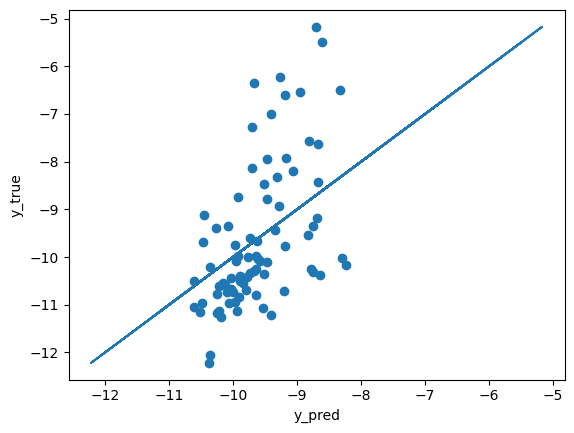

In [390]:
for x in train_loader:
    Y_pred = pymodel(x)
    break
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(Y_pred.detach().numpy(), x.y.detach().numpy())
plt.plot(x.y.detach().numpy(),x.y.detach().numpy())
print('Mse loss', Functional.mse_loss(Y_pred, x.y.unsqueeze(1)))
plt.xlabel('y_pred')
plt.ylabel('y_true')

plt.show()

In [250]:

output_model_path = os.getcwd()+'/training/test/output_model.pth'
chkpt_path = os.getcwd()+"/training/SchNet_target_1K_test_5e4lr/epoch=223-val_loss=0.37-other_metric=0.00.ckpt"
def save_3d_repr(output_model_path,chkpt_path):
    graph_pred_linear = torch.nn.Linear(emb_dim, num_tasks)
    pymodel = Pymodel.load_from_checkpoint(chkpt_path)
    #model.eval()
    molecule_3D_repr = pymodel.molecule_3D_repr
    molecule_3D_repr.eval()
    saved_model_dict = {}
    saved_model_dict["model"] = molecule_3D_repr.state_dict()
    torch.save(saved_model_dict, output_model_path)
def load_3d_rpr(model, output_model_path):
    saved_model_dict = torch.load(output_model_path)
    model.load_state_dict(saved_model_dict["model"])
    return model
save_3d_repr(output_model_path,chkpt_path)
model = load_3d_rpr(model, output_model_path)
#torch.jit.save(torch.jit.script(model_1K), "SchNet_151123.pt")

c:\cond\envs\Geom3D\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
c:\cond\envs\Geom3D\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'graph_pred_linear' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_pred_linear'])`.


In [297]:
#!python src/geom3d/fragencoding.py --config_dir /training/test
from geom3d import fragencoding 
from geom3d.config_utils import read_config
importlib.reload(fragencoding)
config_dir = os.getcwd()+"/test"
config = read_config(config_dir)
os.chdir(config["running_dir"])
np.random.seed(config["seed"])
torch.cuda.manual_seed_all(config["seed"])
config["device"] = (
    "cuda" if torch.cuda.is_available() else torch.device("cpu")
)
model_config = config["model"]
model = SchNet(
    hidden_channels=model_config["emb_dim"],
    num_filters=model_config["SchNet_num_filters"],
    num_interactions=model_config["SchNet_num_interactions"],
    num_gaussians=model_config["SchNet_num_gaussians"],
    cutoff=model_config["SchNet_cutoff"],
    readout=model_config["SchNet_readout"],
    node_class=model_config["node_class"],
)
dataset = fragencoding.load_data(config, model)
train_loader, val_loader, test_loader = fragencoding.train_val_test_split(
    dataset, config=config
)
for x in enumerate(train_loader):
    print(x)

C:\Users\ma11115\OneDrive - Imperial College London\Geom3d\Geom3D\src\geom3d\Database_utils.py:106: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(df_path)


train_idx:  [83 53 70 45 44 39 22 80 10  0 18 30 73 33 90  4 76 77 12 31 55 88 26 42
 69 15 40 96  9 72 11 47 85 28 93  5 66 65 35 16 49 34  7 95 27 19 81 25
 62 13 24  3 17 38  8 78  6 64 36 89 56 99 54 43 50 67 46 68 61 97 79 41
 58 48 98 57 75 32 94 59]
valid_idx:  [63 84 37 29  1 52 21  2 23 87]
test_idx:  [91 74 86 82 20 60 71 14 92 51]
(0, DataBatch(x=[80, 768], y=[80, 128], InChIKey=[80], batch=[80], ptr=[81]))


In [303]:
with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(config["device"])
        print(batch)
        break


DataBatch(x=[4, 768], y=[4, 128], InChIKey=[4], batch=[4], ptr=[5])


In [308]:

x[1].x 

tensor([[ 8.4451e-01,  6.4419e-01,  1.7831e-01,  ..., -2.9693e-01,
         -3.4340e-01,  6.9320e-01],
        [ 1.3097e+00,  1.2238e-01,  1.4261e-03,  ...,  2.4758e-01,
         -4.1374e-01,  1.4865e+00],
        [ 1.4922e+00,  9.4136e-01, -1.3013e-01,  ..., -1.7008e-02,
         -3.8835e-02, -3.7324e-01],
        [ 3.3586e-01,  1.8002e-02,  4.5859e-01,  ..., -1.7008e-02,
         -3.8834e-02, -3.7324e-01]], grad_fn=<CatBackward0>)

In [306]:
with torch.no_grad():
    train_dataset = [dataset[x] for x in [0,1,2,3]]
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,)
for x in enumerate(train_loader):
    print(x)

(0, DataBatch(x=[4, 768], y=[4, 128], InChIKey=[4], batch=[4], ptr=[5]))


In [26]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import wandb
os.chdir("/rds/general/user/ma11115/home/Geom3D/Geom3D/training")
dir = "/rds/general/user/ma11115/home/Geom3D/Geom3D/training"
wandb.login()
name = "SchNet_target_1K_TEST_5e4lr" 
# model
pymodel_SCHNET = Pymodel(model,graph_pred_linear)
wandb_logger = WandbLogger(log_model="all",project="Geom3D",name=name)
# train model
checkpoint_callback = ModelCheckpoint(
    dirpath= name,
    filename='{epoch}-{val_loss:.2f}-{other_metric:.2f}',
    monitor="val_loss", mode="min"
)

trainer = pl.Trainer(logger=wandb_logger, max_epochs=30,val_check_interval=1.0,log_every_n_steps=1, callbacks=[checkpoint_callback])
trainer.fit(model=pymodel_SCHNET, train_dataloaders=train_loader, val_dataloaders=val_loader)
wandb.finish()

ModuleNotFoundError: No module named 'lightning'

In [ ]:
name = "SchNet_target_1K_TEST_5e4lr_1" 
wandb_logger = WandbLogger(log_model="all",project="Geom3D",name=name)
# train model
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
trainer = pl.Trainer(logger=wandb_logger, max_epochs=50,val_check_interval=1.0,log_every_n_steps=1, callbacks=[checkpoint_callback])
trainer.fit(model=pymodel_SCHNET, train_dataloaders=train_loader, val_dataloaders=val_loader,ckpt_path="/rds/general/user/ma11115/home/Geom3D/Geom3D/training/Geom3D/8scxed0p/checkpoints/epoch=29-step=210.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/rds/general/user/ma11115/home/anaconda3/envs/Geom3D/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
Restoring states from the checkpoint path at /rds/general/user/ma11115/home/Geom3D/Geom3D/training/Geom3D/8scxed0p/checkpoints/epoch=29-step=210.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name              | Type   | Params
---------------------------------------------
0 | molecule_3D_repr  | SchNet | 483 K 
1 | graph_pred_linear | Linear | 129   
---------------------------------------------
483 K     Trainable param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Notice that till here we are only using a randomly-initialized SchNet to make predictions, i.e., no optimization is conducted. We will show how to do this in the following tutorials.

AttributeError: 'Pymodel' object has no attribute 'epochs'

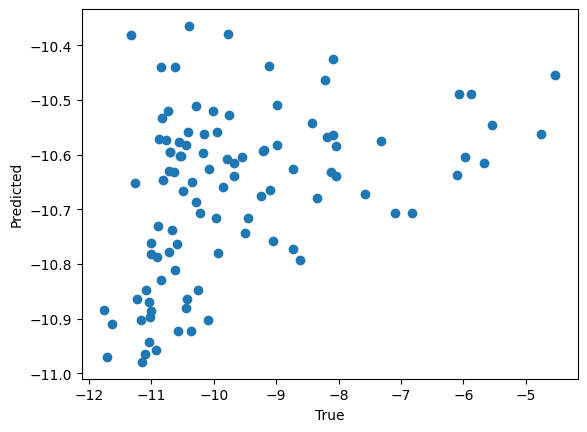

In [ ]:
# plot the results
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(y_true, y_scores)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()